In [3]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"],
                                            "id": dq_dict_ak1["gpid"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename = "/data/t3home000/dhoang/DQ/outfiles/DY_Jun1621_100k.root"
dq_events = getData(filename, treeName = 'Events')

Saving plots to:  plot/17-06-2021


## Mass resolution

In [4]:
def create_partiles_momenta(px,py,pz):
    
    p1 = np.transpose(np.stack((px[:,0], py[:,0], pz[:,0])))
    p2 = np.transpose(np.stack((px[:,1], py[:,1], pz[:,1])))
    
    return p1,p2

def seagull_sailor_test(dq_events):
    
    #Select the events that are reconstructed
    reco_selection = np.asarray(ak.num(dq_events["truth_dimuon"].mass) < 2) &\
                     np.asarray(ak.num(dq_events["GenVertex"].px) < 3)
    
    truth_selected = copy.deepcopy(dq_events["truth_dimuon"].mass[reco_selection])
    id_selected = copy.deepcopy(dq_events["GenVertex"].id[reco_selection])
    
    #Select the momentum
    truth_px_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].px[reco_selection]))
    truth_py_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].py[reco_selection]))
    truth_pz_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].pz[reco_selection]))
    
    #Create the momenta of the first and second muon
    p1, p2 = create_partiles_momenta(truth_px_selected,
                                     truth_py_selected,
                                     truth_pz_selected)
    
    #Calculate the cross product in the y direction
    cross_y = np.cross(p1,p2)[:,1]
    
    #Assuming that the first particle is an antimuon,
    #second particle is muon
    muon_order = (id_selected[:,0] == -13) & (id_selected[:,1] == 13)
    
    seagull_select = ((cross_y > 0) & muon_order)|\
                     ((cross_y < 0) & np.invert(muon_order))
    
    sailor_select = ((cross_y < 0) & muon_order)|\
                    ((cross_y > 0) & np.invert(muon_order))
    
    
    print("Seagull: {} Events".format(sum(seagull_select)))
    print("Sailor: {} Events".format(sum(sailor_select)))
    
seagull_sailor_test(dq_events)

Seagull: 50272 Events
Sailor: 49708 Events


In [15]:
def create_partiles_momenta(px,py,pz):
    
    p1 = np.transpose(np.stack((px[:,0], py[:,0], pz[:,0])))
    p2 = np.transpose(np.stack((px[:,1], py[:,1], pz[:,1])))
    
    return p1,p2

def plot_mass_res(event_label, dy, truth):
    
    residual = np.asarray(dy) - np.asarray(truth)
    
    plot_bins = 50
    plot_range = (-2,2)
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range, density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=[1, 0, 0.2])
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [GeV]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [GeV]'%abs(popt[2]))
    
    #Label the axes
    plt.xlabel(r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]')
    plt.ylabel('Normalized counts')
    plt.title(event_label)

    plt.legend()
    
    plt.show()



def seagull_sailor_res(dq_events):
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].mass, axis = 1) &\
                     (ak.num(dq_events["truth_dimuon"].mass) < 2) #Remove those with 4 truth muons
    
    dy_selected = copy.deepcopy(dq_events["reco_dimuon"].mass[reco_selection])
    truth_selected = copy.deepcopy(dq_events["truth_dimuon"].mass[reco_selection])
    id_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].id[reco_selection]))
    
    #Select the momentum
    truth_px_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].px[reco_selection]))
    truth_py_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].py[reco_selection]))
    truth_pz_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].pz[reco_selection]))
    
    #Create the momenta of the first and second muon
    p1, p2 = create_partiles_momenta(truth_px_selected,
                                     truth_py_selected,
                                     truth_pz_selected)
    
    #Calculate the cross product in the y direction
    cross_y = np.cross(p1,p2)[:,1]
    
    print(cross_y)
    
    #Assuming that the first particle is an antimuon,
    #second particle is muon
    muon_order = (id_selected[:,0] == -13) & (id_selected[:,1] == 13)
    
    seagull_select = ((cross_y > 0) & muon_order)|\
                     ((cross_y < 0) & np.invert(muon_order))
    
    sailor_select = ((cross_y < 0) & muon_order)|\
                    ((cross_y > 0) & np.invert(muon_order))
    
    print("Seagull: {} Events".format(sum(seagull_select)))
    print("Sailor: {} Events".format(sum(sailor_select)))
    
#     #select seagull and sailor
#     seagull_dy_selected = dy_selected[seagull_select]
#     seagull_truth_selected = truth_selected[seagull_select]
    
#     sailor_dy_selected = dy_selected[sailor_select]
#     sailor_truth_selected = truth_selected[sailor_select]
    
#     plot_mass_res("Seagull", seagull_dy_selected, seagull_truth_selected)
#     plot_mass_res("Sailor", sailor_dy_selected, sailor_truth_selected)
    
    
seagull_sailor_res(dq_events)

[160.02531 151.88916 167.15192 ... 236.59103 115.65306 187.79178]
Seagull: 5806 Events
Sailor: 0 Events


## Mass scale

Seagull: 1676 Events
Sailor: 1182 Events
Truth momentum range: 60,80 GeV
Error for parameter esimations:  [0.04321703 0.02256308 0.01800967]
Standard deviation (fit) is 0.4813887513233613
Mean (fit) is 0.17254514724637623
Truth momentum range: 80,100 GeV
Error for parameter esimations:  [0.03794759 0.01859767 0.01331254]
Standard deviation (fit) is 0.4730757748174837
Mean (fit) is 0.1342209257129817
Truth momentum range: 100,120 GeV
Error for parameter esimations:  [0.07985289 0.06787018 0.07220241]
Standard deviation (fit) is 0.5746422850070292
Mean (fit) is 0.013573822798782375
Truth momentum range: 60,80 GeV
Error for parameter esimations:  [0.04805875 0.01994046 0.0157396 ]
Standard deviation (fit) is 0.4363844891149873
Mean (fit) is 0.1643245660012209
Truth momentum range: 80,100 GeV
Error for parameter esimations:  [0.04413306 0.01911536 0.01513742]
Standard deviation (fit) is 0.45105820272456937
Mean (fit) is 0.18440995674651023
Truth momentum range: 100,120 GeV
Error for parame

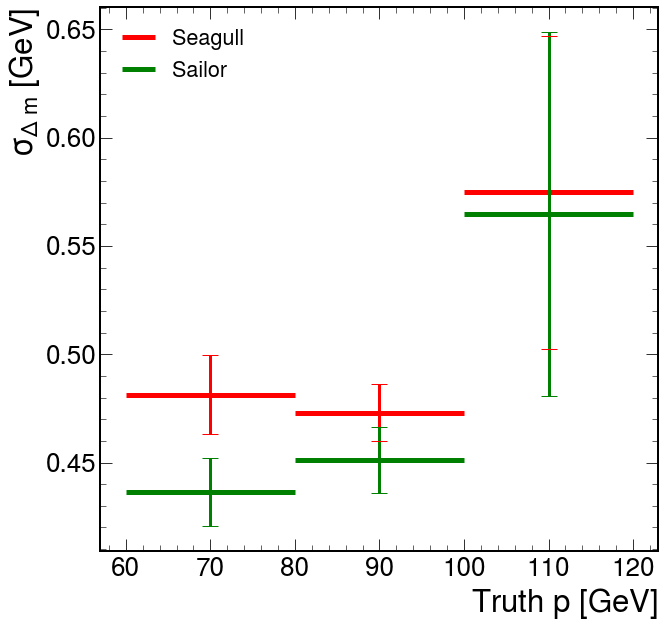

In [6]:
def create_partiles_momenta(px,py,pz):
    
    p1 = np.transpose(np.stack((px[:,0], py[:,0], pz[:,0])))
    p2 = np.transpose(np.stack((px[:,1], py[:,1], pz[:,1])))
    
    return p1,p2

def plot_mass_scale(event_label, dy_selected, truth_selected, truth_p_selected):
    
    residual = np.asarray(dy_selected) - np.asarray(truth_selected)
    
    plot_bins = 50
    plot_range = (-2,2)
    
    m_resolution = [] #To save the resolution (sigma) of the fit
    m_err = []
    p_ranges = []
    p_average = []
    
    
    #Loop over different average p range
    for i in range(3):
        
        p_range = 20
        p_min = i*p_range + 60 #GeV
        p_max = (i+1)*p_range + 60
        p_ranges.append([p_min,p_max]) #Save for plotting resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p_selected > p_min) & (truth_p_selected < p_max)
        p_average.append(np.mean(truth_p_selected[local_selection]))
        
        residual = copy.deepcopy(np.asarray(dy_selected[local_selection] - truth_selected[local_selection]))
        
        
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(residual, bins=bins,
                                       range = plot_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[0.1, 0, 0.5])


        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        m_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        m_resolution.append(std_fit)

        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)
        
    
    #Plot how the resolution scale
    
    if event_label == "Seagull":
        plt.hlines(m_resolution,
                   [x[0] for x in p_ranges],
                   [x[1] for x in p_ranges],
                   color = "r",
                   lw=5,
                   linestyles='solid',
                   label = event_label)
        
        #Plot the error bars
        plt.errorbar([np.average(x) for x in p_ranges],
                    m_resolution,
                    color = "r",
                    yerr=m_err,
                    fmt='none',
                    elinewidth=3,
                    capsize=8)
    else:
        plt.hlines(m_resolution,
                   [x[0] for x in p_ranges],
                   [x[1] for x in p_ranges],
                   color = "g",
                   lw=5,
                   linestyles='solid',
                   label = event_label)
        #Plot the error bars
        plt.errorbar([np.average(x) for x in p_ranges],
                    m_resolution,
                    color = "g",
                    yerr=m_err,
                    fmt='none',
                    elinewidth=3,
                    capsize=8)




def seagull_sailor_res_mscale(dq_events):
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].mass, axis = 1) &\
                     (ak.num(dq_events["truth_dimuon"].mass) < 2) #Remove those with 4 truth muons
    
    dy_selected = copy.deepcopy(dq_events["reco_dimuon"].mass[reco_selection])
    truth_selected = copy.deepcopy(dq_events["truth_dimuon"].mass[reco_selection])
    id_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].id[reco_selection]))
    
    
    #Select the truth momentum range as well
    truth_p_selected = np.linalg.norm([ak.flatten(dq_events["truth_dimuon"].px[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].py[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].pz[reco_selection])],axis = 0)
    
    #Select the momentum
    truth_px_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].px[reco_selection]))
    truth_py_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].py[reco_selection]))
    truth_pz_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].pz[reco_selection]))
    
    #Create the momenta of the first and second muon
    p1, p2 = create_partiles_momenta(truth_px_selected,
                                     truth_py_selected,
                                     truth_pz_selected)
    
    #Calculate the cross product in the z direction
    cross_z = np.cross(p1,p2)[:,2]
    
    print("Seagull: {} Events".format(sum(cross_z > 0)))
    print("Sailor: {} Events".format(sum(cross_z < 0)))
    
    #select seagull and sailor
    seagull_dy_selected = dy_selected[cross_z > 0]
    seagull_truth_selected = truth_selected[cross_z > 0]
    seagull_truth_p_selected = truth_p_selected[cross_z > 0]
    
    sailor_dy_selected = dy_selected[cross_z < 0]
    sailor_truth_selected = truth_selected[cross_z < 0]
    sailor_truth_p_selected = truth_p_selected[cross_z < 0]
    
    
    plot_mass_scale("Seagull", seagull_dy_selected,
                               seagull_truth_selected,
                               seagull_truth_p_selected)
    
    plot_mass_scale("Sailor", sailor_dy_selected,
                              sailor_truth_selected,
                              sailor_truth_p_selected)
    
    plt.xlabel(r'Truth $p$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~m}$ [GeV]')
    
    plt.legend()
    plt.show()
    
seagull_sailor_res_mscale(dq_events)

## Momentum rms versus p

In [ ]:
def create_partiles_momenta(px,py,pz):
    
    p1 = np.transpose(np.stack((px[:,0], py[:,0], pz[:,0])))
    p2 = np.transpose(np.stack((px[:,1], py[:,1], pz[:,1])))
    
    return p1,p2

def select_pz(dq_events, selection):
    
    GenMuons = dq_events['GenP_St1']
    RecoMuons = dq_events["Track_St1"]
    GenVertices = dq_events['GenVertex']
    nTracks = dq_events['nTrack']
    
    #Dictionary to hold saved arrays
    track_dict = {}
    
    # only look at the events with two tracks reconstructed for now
    # because it is easier to match the pz
    for num_track in [1,2]:
        events_selected = (nTracks.n_tracks == num_track)
        RecoMuons_selected = RecoMuons[events_selected]
        GenMuons_selected = GenMuons[events_selected]
        GenVertices_selected = GenVertices[events_selected]
        
        if num_track == 1:
            #Match based on the closest pz
            match_index = ak.argmin(abs(GenMuons_selected.pz - ak.flatten(RecoMuons_selected.pz)),
                                    axis=1, keepdims=True)
            
            track_dict['truth_pz_1track'] = GenMuons_selected[match_index].pz
            track_dict['reco_pz_1track'] = RecoMuons_selected.pz #since there is only 1 track
            
        elif num_track == 2:
            #Max case
            index_gen_pzmax = ak.argmax(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmax = ak.argmax(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            
            track_dict['truth_pz_max2track'] = GenMuons_selected[index_gen_pzmax].pz
            track_dict['reco_pz_max2track'] = RecoMuons_selected[index_reco_pzmax].pz
            
            #Min case
            index_gen_pzmin = ak.argmin(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmin = ak.argmin(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            track_dict['truth_pz_min2track'] = GenMuons_selected[index_gen_pzmin].pz
            track_dict['reco_pz_min2track'] = RecoMuons_selected[index_reco_pzmin].pz
    
    
    #Concatenate the matched tracks together
    all_truth_pz = np.asarray(ak.flatten(np.concatenate([track_dict['truth_pz_1track'],
                                      track_dict['truth_pz_max2track'],
                                      track_dict['truth_pz_min2track']])))
    
    all_reco_pz =  np.asarray(ak.flatten(np.concatenate([track_dict['reco_pz_1track'],
                                     track_dict['reco_pz_max2track'],
                                     track_dict['reco_pz_min2track']])))

def plot_momentum_scale(event_label, dy_selected, truth_selected, truth_p_selected):
    
    residual = np.asarray(dy_selected) - np.asarray(truth_selected)
    
    plot_bins = 50
    plot_range = (-2,2)
    
    m_resolution = [] #To save the resolution (sigma) of the fit
    m_err = []
    p_ranges = []
    p_average = []
    
    
    #Loop over different average p range
    for i in range(3):
        
        p_range = 20
        p_min = i*p_range + 60 #GeV
        p_max = (i+1)*p_range + 60
        p_ranges.append([p_min,p_max]) #Save for plotting resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p_selected > p_min) & (truth_p_selected < p_max)
        p_average.append(np.mean(truth_p_selected[local_selection]))
        
        residual = copy.deepcopy(np.asarray(dy_selected[local_selection] - truth_selected[local_selection]))
        
        
        
        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(residual, bins=bins,
                                       range = plot_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[0.1, 0, 0.5])


        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        m_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        m_resolution.append(std_fit)

        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)

        
    #Plot how the resolution scale
    
    if event_label == "Seagull":
        plt.hlines(p_resolution,
                   [x[0] for x in p_ranges],
                   [x[1] for x in p_ranges],
                   color = "r",
                   lw=5,
                   linestyles='solid',
                   label = event_label)
        
        #Plot the error bars
        plt.errorbar([np.average(x) for x in p_ranges],
                    p_resolution,
                    color = "r",
                    yerr=p_err,
                    fmt='none',
                    elinewidth=3,
                    capsize=8)
    else:
        plt.hlines(p_resolution,
                   [x[0] for x in p_ranges],
                   [x[1] for x in p_ranges],
                   color = "g",
                   lw=5,
                   linestyles='solid',
                   label = event_label)
        #Plot the error bars
        plt.errorbar([np.average(x) for x in p_ranges],
                    p_resolution,
                    color = "g",
                    yerr=p_err,
                    fmt='none',
                    elinewidth=3,
                    capsize=8)




def seagull_sailor_res_pscale(dq_events):
    
    #Select the events that are reconstructed
    reco_selection = ak.any(dq_events["reco_dimuon"].mass, axis = 1) &\
                     (ak.num(dq_events["truth_dimuon"].mass) < 2) #Remove those with 4 truth muons
    
    dy_selected = copy.deepcopy(dq_events["reco_dimuon"].mass[reco_selection])
    truth_selected = copy.deepcopy(dq_events["truth_dimuon"].mass[reco_selection])
    
    #Select the truth momentum range as well
    truth_p_selected = np.linalg.norm([ak.flatten(dq_events["truth_dimuon"].px[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].py[reco_selection]),
                                       ak.flatten(dq_events["truth_dimuon"].pz[reco_selection])],axis = 0)
    
    #Select the momentum
    truth_px_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].px[reco_selection]))
    truth_py_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].py[reco_selection]))
    truth_pz_selected = copy.deepcopy(np.asarray(dq_events["GenVertex"].pz[reco_selection]))
    
    #Create the momenta of the first and second muon
    p1, p2 = create_partiles_momenta(truth_px_selected,
                                     truth_py_selected,
                                     truth_pz_selected)
    
    #Calculate the cross product in the z direction
    cross_z = np.cross(p1,p2)[:,2]
    
    print("Seagull: {} Events".format(sum(cross_z > 0)))
    print("Sailor: {} Events".format(sum(cross_z < 0)))
    
    #select seagull and sailor
    seagull_dy_selected = dy_selected[cross_z > 0]
    seagull_truth_selected = truth_selected[cross_z > 0]
    seagull_truth_p_selected = truth_p_selected[cross_z > 0]
    
    sailor_dy_selected = dy_selected[cross_z < 0]
    sailor_truth_selected = truth_selected[cross_z < 0]
    sailor_truth_p_selected = truth_p_selected[cross_z < 0]
    
    
    plot_momentum_scale("Seagull", seagull_dy_selected,
                               seagull_truth_selected,
                               seagull_truth_p_selected)
    
    plot_momentum_scale("Sailor", sailor_dy_selected,
                              sailor_truth_selected,
                              sailor_truth_p_selected)
    
    plt.xlabel(r'Truth $p_z$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~p_z}$ [GeV]')
    
    plt.legend()
    plt.show()
    
seagull_sailor_res_pscale(dq_events)

Truth momentum range: 0,30 GeV
Error for parameter esimations:  [0.0472536  0.00897271 0.00704119]
Standard deviation (fit) is 0.3042481159185194
Mean (fit) is -0.004917128523379693
Resolution (fit) is -61.87516036481397


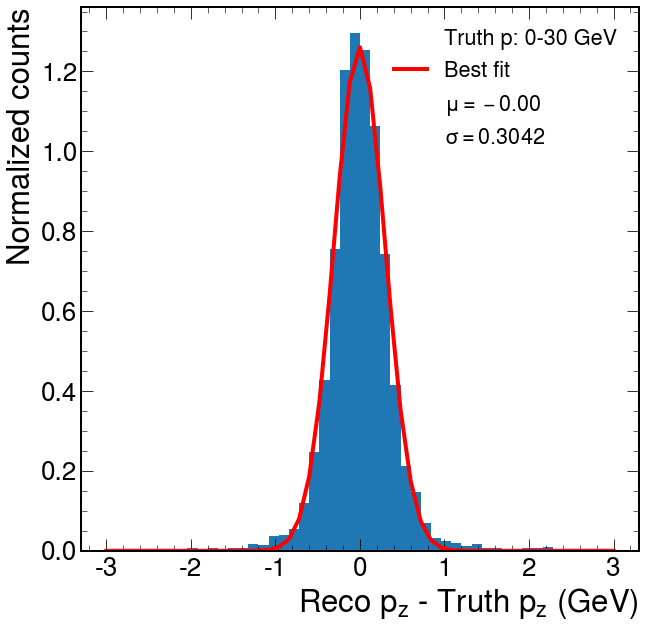

Truth momentum range: 30,60 GeV
Error for parameter esimations:  [0.02999709 0.0142259  0.01147537]
Standard deviation (fit) is 0.4831859407026149
Mean (fit) is -0.007025744840642504
Resolution (fit) is -68.77362495539015


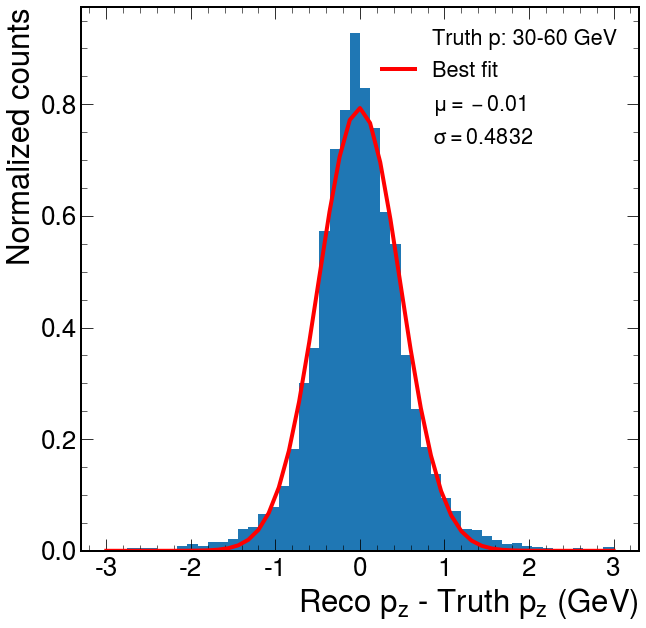

Truth momentum range: 60,90 GeV
Error for parameter esimations:  [0.04855924 0.08171103 0.07704092]
Standard deviation (fit) is 0.8169425674590189
Mean (fit) is -0.029667579389337662
Resolution (fit) is -27.536542726927795


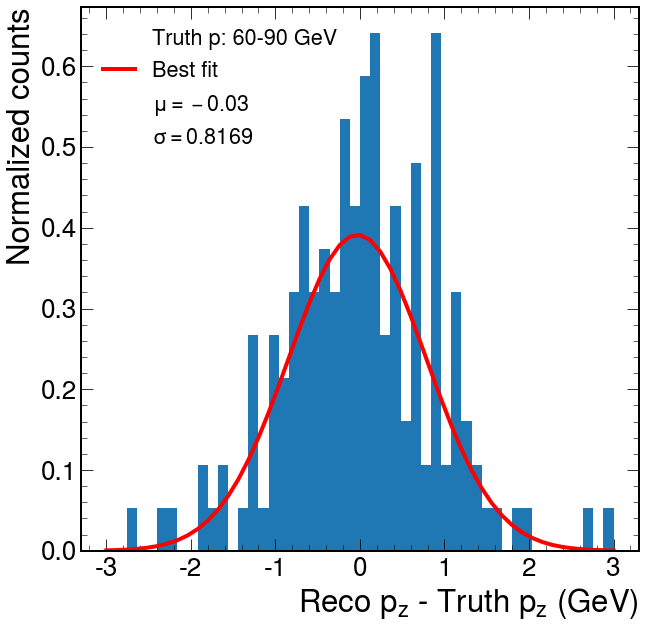

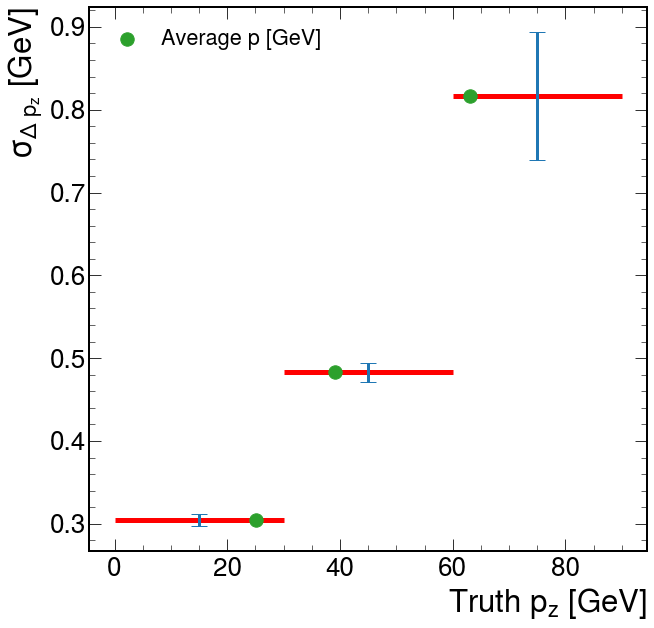

In [30]:
def processor(dq_events):
    
    GenMuons = dq_events['GenP_St1']
    RecoMuons = dq_events["Track_St1"]
    GenVertices = dq_events['GenVertex']
    nTracks = dq_events['nTrack']
    
    #Dictionary to hold saved arrays
    track_dict = {}
    
    # only look at the events with two tracks reconstructed for now
    # because it is easier to match the pz
    for num_track in [1,2]:
        events_selected = (nTracks.n_tracks == num_track)
        RecoMuons_selected = RecoMuons[events_selected]
        GenMuons_selected = GenMuons[events_selected]
        GenVertices_selected = GenVertices[events_selected]
        
        if num_track == 1:
            #Match based on the closest pz
            match_index = ak.argmin(abs(GenMuons_selected.pz - ak.flatten(RecoMuons_selected.pz)),
                                    axis=1, keepdims=True)
            
            track_dict['truth_pz_1track'] = GenMuons_selected[match_index].pz
            track_dict['reco_pz_1track'] = RecoMuons_selected.pz #since there is only 1 track
            
        elif num_track == 2:
            #Max case
            index_gen_pzmax = ak.argmax(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmax = ak.argmax(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            
            track_dict['truth_pz_max2track'] = GenMuons_selected[index_gen_pzmax].pz
            track_dict['reco_pz_max2track'] = RecoMuons_selected[index_reco_pzmax].pz
            
            #Min case
            index_gen_pzmin = ak.argmin(GenMuons_selected.pz, axis=1, keepdims=True)
            index_reco_pzmin = ak.argmin(RecoMuons_selected.pz, axis=1, keepdims=True)
            
            track_dict['truth_pz_min2track'] = GenMuons_selected[index_gen_pzmin].pz
            track_dict['reco_pz_min2track'] = RecoMuons_selected[index_reco_pzmin].pz
    
    
    #Concatenate the matched tracks together
    all_truth_pz = np.asarray(ak.flatten(np.concatenate([track_dict['truth_pz_1track'],
                                      track_dict['truth_pz_max2track'],
                                      track_dict['truth_pz_min2track']])))
    
    all_reco_pz =  np.asarray(ak.flatten(np.concatenate([track_dict['reco_pz_1track'],
                                     track_dict['reco_pz_max2track'],
                                     track_dict['reco_pz_min2track']])))
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_average = []
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in list(range(3)):
        
        p_range = 30
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (all_truth_pz > p_min) & (all_truth_pz < p_max)
        p_average.append(np.mean(all_truth_pz[local_selection]))
        
        p_residual = copy.deepcopy(all_reco_pz[local_selection] - all_truth_pz[local_selection])
        
        #Initial distribution and labelling
        plt.hist(p_residual,
                 bins = 50,
                 range = (-3, 3),
                 density = True)
        plt.plot([],[], 'none', label="Truth p: {}-{} GeV".format(p_min, p_max))
        
        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

        bins = np.linspace(-3, 3, 51)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(p_residual, bins=bins,
                                       range = (-3, 3), density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        popt, pcov = curve_fit(fit_function,
                               xdata=binscenters[mask],
                               ydata=data_entries[mask],
                               sigma = np.sqrt(data_entries[mask]),
                               absolute_sigma = False,
                               p0=[1, 0, 0.5])

        #Error for parameter estimations
        perr = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", perr)
        p_err.append(perr[2])

        std_fit = np.abs(popt[2])
        mean_fit = popt[1]
        res_fit = std_fit/mean_fit
        sigma_res = perr[2]/mean_fit
        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)
        print("Resolution (fit) is {}".format(res_fit))
        p_resolution.append(std_fit)

        #Plot fitted gaussian
        plt.plot(bins,
                 fit_function(bins, *popt),
                 "r-",
                 linewidth=4,
                 label='Best fit')
        
        plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[2])
        
        #Label the axes
        plt.xlabel(r'Reco $p_z$ - Truth $p_z$ (GeV)')
        plt.ylabel('Normalized counts')
        
        plt.legend()
        plt.show()
        
        
    #MAIN PLOT
    #Plot momentum average
    plt.scatter(p_average, p_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
    #Plot the resolution based on momentum range. 
    plt.hlines(p_resolution,
               [x[0] for x in p_ranges],
               [x[1] for x in p_ranges],
               colors='r', lw=5,
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in p_ranges],
                p_resolution,
                yerr=p_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    plt.xlabel(r'Truth $p_z$ [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~p_z}$ [GeV]')
    
    plt.legend()
    plt.show()
    
processor(dq_events)